In [13]:
import argparse
from pprint import pp
import torch
from torch import nn
from tqdm import tqdm
import numpy as np
import json
import os
from omegaconf import OmegaConf
from torch.utils.tensorboard import SummaryWriter

from utils import load_dataset, load_config
from utils import get_model
from utils import get_loss_hparams_and_lr, get_loss
from utils import trainer
from utils import utils
import matplotlib.pyplot as plt

In [14]:
#set torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#code in this file will serve as a denoising test of the trained ne_lpn model

dataset_config_path = "../exps/mnist/configs/mnist/test_dataset.json"


In [15]:
def run_test(network_type, shift_factor, model_path, dataset_config_path, model_weight_path):
    # load model and dataset
    model_config = load_config(model_path)
    model = get_model(model_config)
    model.load_state_dict(torch.load(model_weight_path)["model_state_dict"])

    dataset_config = load_config(dataset_config_path)
    test_dataset = load_dataset(dataset_config, "test")

    #get the data loader
    test_data_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, shuffle=False, num_workers=4
    )

    for step, batch in enumerate(test_data_loader):
        # get first image from the test data loader
        clean_image = batch["image"].to(device)
        output_clean = model(clean_image)
    
        # shift all values in clean_image by shift_factor by adding tensor of shift_factor
        shift_tensor = torch.full_like(clean_image, shift_factor)
        shifted_image = clean_image + shift_tensor
        output_shifted = model(shifted_image)

        if step == 0:
            #plot the four images ( using matplotlib
            fig, axs = plt.subplots(2, 2)
            axs[0, 0].imshow(clean_image[0][0].cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
            axs[0, 0].set_title('Input Image Unshifted')
            axs[0, 0].axis('off')
            axs[0, 1].imshow(output_clean[0][0].cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
            axs[0, 1].set_title('Model Output from Clean Image')
            axs[0, 1].axis('off')
            axs[1, 0].imshow(shifted_image[0][0].cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
            axs[1, 0].set_title('Input Image Shifted')
            axs[1, 0].axis('off')
            axs[1, 1].imshow(output_shifted[0][0].cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
            axs[1, 1].set_title('Model Output from Shifted Image')
            axs[1, 1].axis('off')
        
            loss = nn.MSELoss()
    
            output_clean_shifted = output_clean + shift_tensor
            mse_loss = loss(output_clean_shifted, output_shifted)
        
            print(f"mse loss: {mse_loss}")
    
            #below the plot show the mse of the shifted output vs the unshifted output plus the shit factor
            plt.suptitle(f"Network: {network_type} | Shift factor: {shift_factor}")
        
            # show the text below the plot
            if mse_loss.item() < 0.0001:
                rounded_loss = f"{mse_loss.item():.4e}"
            else:
                rounded_loss = f"{mse_loss.item():.4f}"
            plt.text(0.5, -0.2, f"MSE between shifted output and unshifted output plus shift factor: {rounded_loss}", horizontalalignment='center', verticalalignment='center', transform=axs[1, 1].transAxes)
            #show the plot
            plt.show()

            #save the plot and break
            if not os.path.exists("shift_experiment"):
                os.makedirs("shift_experiment")
            fig.savefig(f"shift_experiment/{network_type}_shift_{shift_factor}.png")

            break
                     
                    

In [16]:
model_config_paths = {
    "ne": "../exps/mnist/configs/mnist/model_ne.json",
    "lpn": "../exps/mnist/configs/mnist/model.json",
}

model_weight_paths = {
    "ne": "../exps/mnist/experiments/ne_mnist/model.pt",
    "lpn": "../exps/mnist/experiments/mnist/model.pt",
}

dataset_config_path = "../exps/mnist/configs/mnist/test_dataset.json"

In [17]:
shift_factors =  [0.1, 0.2, 0.3, 0.4, 0.5]

init weights
dataset:  mnist
mse loss: 0.010233287699520588


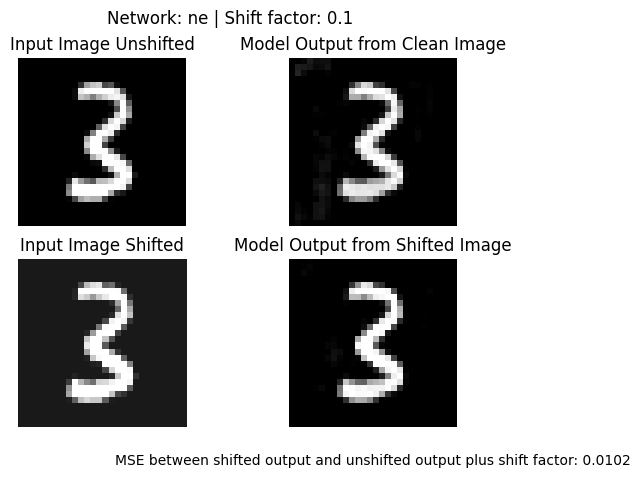

init weights
dataset:  mnist
mse loss: 0.006928416434675455


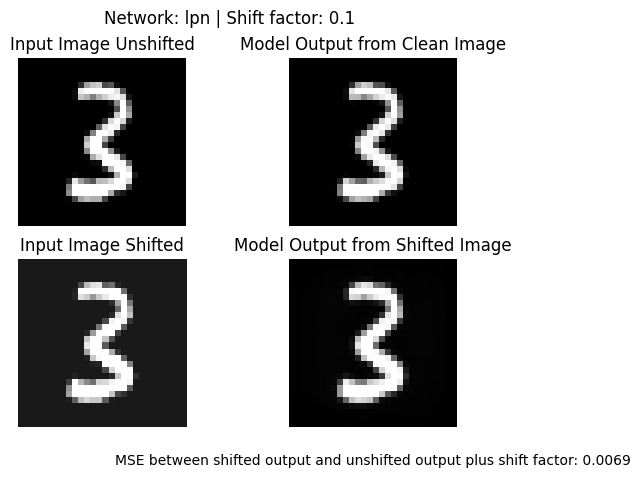

init weights
dataset:  mnist
mse loss: 0.03711682930588722


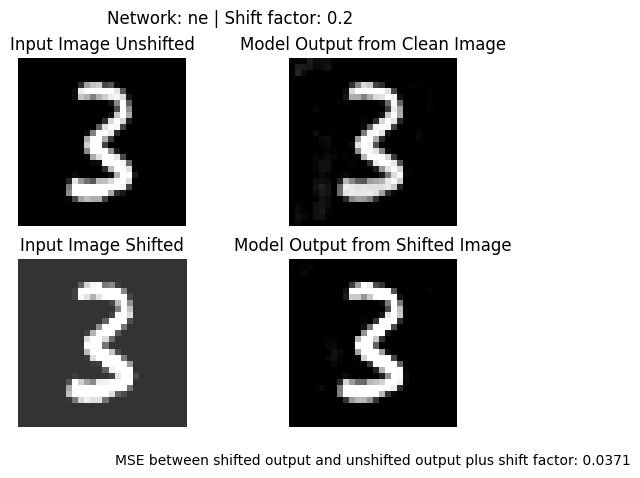

init weights
dataset:  mnist
mse loss: 0.023797305300831795


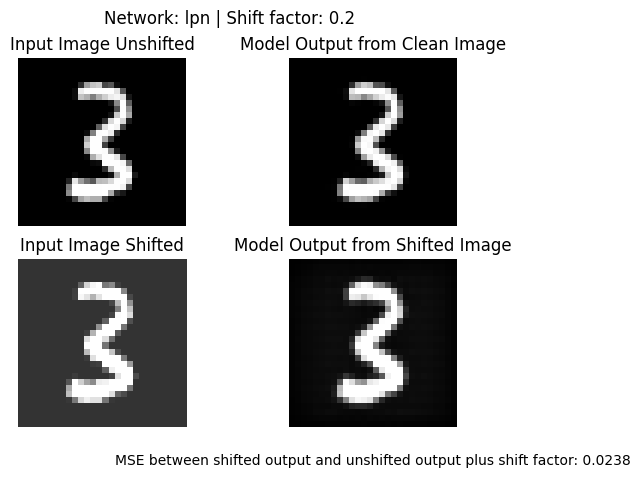

init weights
dataset:  mnist
mse loss: 0.0824352279305458


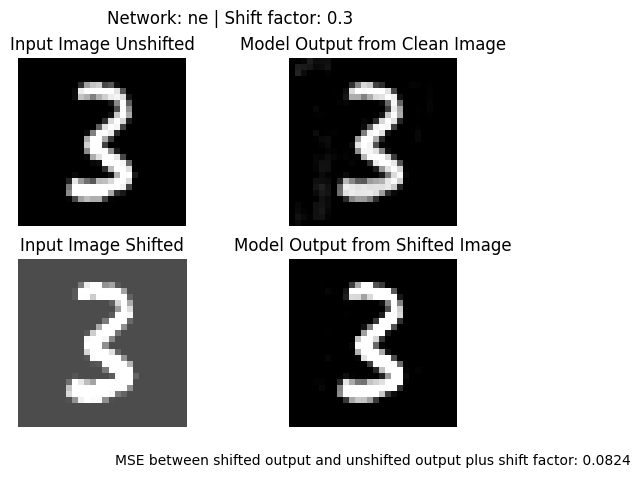

init weights
dataset:  mnist
mse loss: 0.02387143485248089


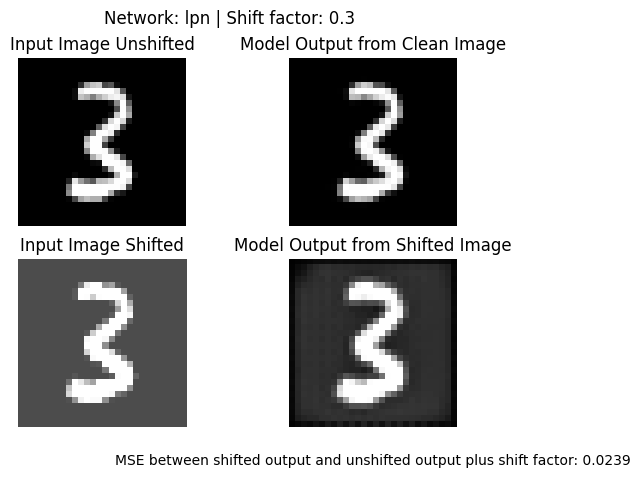

init weights
dataset:  mnist
mse loss: 0.14468255639076233


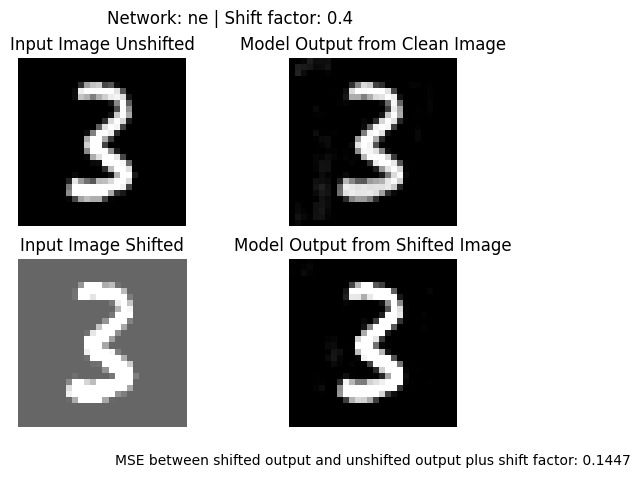

init weights
dataset:  mnist
mse loss: 0.022288473322987556


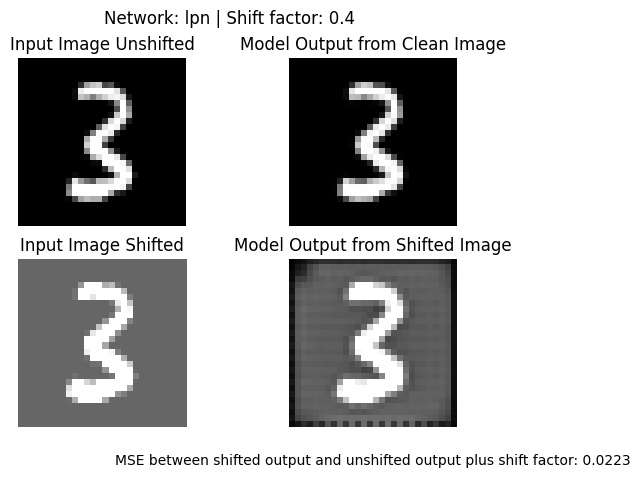

init weights
dataset:  mnist
mse loss: 0.22571443021297455


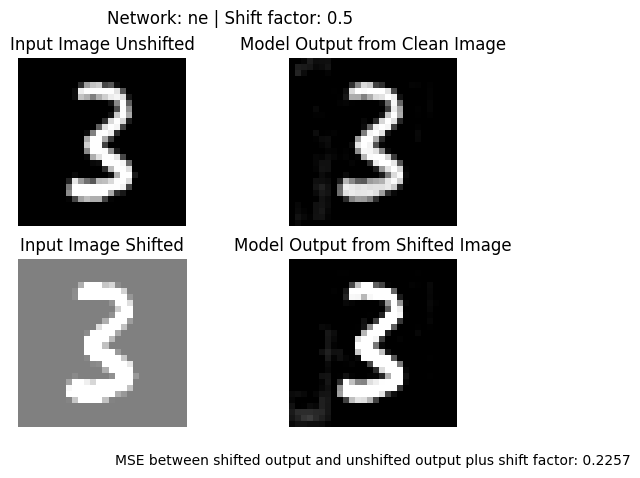

init weights
dataset:  mnist
mse loss: 0.030029084533452988


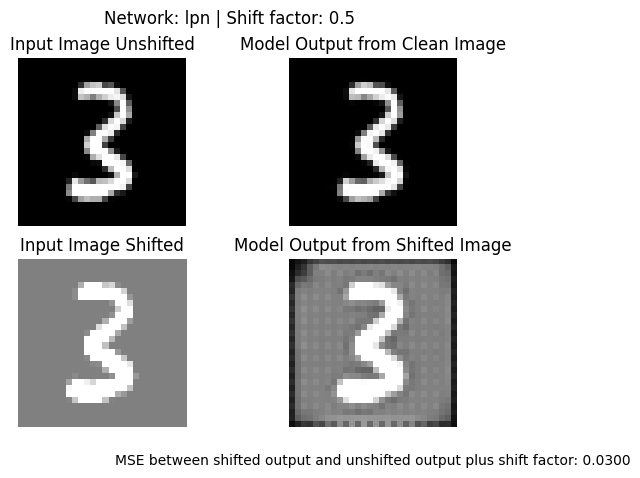

In [18]:
for shift in shift_factors:
    for network_type in model_config_paths:
        run_test(network_type, shift, model_config_paths[network_type], dataset_config_path, model_weight_paths[network_type])